In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from builtins import range
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import mir_eval
import librosa, librosa.display
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Reshape, Dropout, Permute
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import GRU
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"]="0" # the number of the GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1 # percentage to be used
set_session(tf.Session(config=config))

from kapre.time_frequency import Melspectrogram
from global_config import *


Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [25]:
def model_multi_kernel_shape(n_out, input_shape, out_activation='softmax'):
    """

    Symbolic summary:
    > c2' - p2 - c2 - p2 - c2 - p2 - c2 - p3 - d1
    where c2' -> multiple kernel shapes

    Parameters
    ----------
        n_out: integer, number of output nodes
        input_shape: tuple, an input shape, which doesn't include batch-axis.
        out_activation: activation function on the output
    """
    audio_input = Input(shape=input_shape)

    x = Melspectrogram(n_dft=N_FFT, n_hop=HOP_LENGTH, sr=SR, n_mels=128, power_melgram=2.0, return_decibel_melgram=True)(audio_input)
    x = BatchNormalization(axis=channel_axis)(x)

    x1 = Conv2D(7, (20, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x2 = Conv2D(7, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x3 = Conv2D(7, (3, 20), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    x = Concatenate(axis=channel_axis)([x1, x2, x3])

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(21, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(reg_w))(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), padding='same')(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(n_out, activation=out_activation, kernel_regularizer=keras.regularizers.l2(reg_w))(x)

    model = Model(audio_input, out)

    return model

def data_gen(audio_data, n_detect, nsp_excerpt, type_excerpt, hop_length=HOP_LENGTH):
    """Data generator.
    excerpt: data of one audio file.
    n_detect: number of excerpts to be detected.
    nsp_detect: number of samples in one excerpt.
    """
    
    tile_times = int(np.ceil(NSP_SRC/nsp_excerpt))

    while True:
        for i in range(n_detect):
            
            if type_excerpt == 'onset':
                src_batch = np.array([audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)]], dtype=K.floatx())
            elif type_excerpt == 'segment':
                src_batch = np.array([np.tile(audio_data[int(i*hop_length):int(i*hop_length+nsp_excerpt)],tile_times)[:NSP_SRC]],
                                     dtype=K.floatx())
                
            src_batch = src_batch[:, np.newaxis, :]  # make (batch, N) to (batch, 1, N) for kapre compatible
            
            yield src_batch
            

def intervals1tointervals01(segintervals1, paudio_duration):
    idx2del = []
    for idx in np.arange(1,len(segintervals1)):
        if segintervals1[idx-1][1] >= segintervals1[idx][0]:
            segintervals1[idx] = [segintervals1[idx-1][0],segintervals1[idx][1]]
            idx2del.append(idx-1)           
    segintervals1 = np.delete(segintervals1, idx2del, axis=0)  
    
    labels = []
    segintervals01 = np.zeros((len(segintervals1)*2+1,2))
    
    for idx in range(len(segintervals01)):
        if idx==0:
            segintervals01[idx] = [0, segintervals1[0][0]]
            labels.append('np')
        elif idx==len(segintervals01)-1:
            segintervals01[idx] = [segintervals1[-1][-1],paudio_duration]
            labels.append('np')
        elif idx%2:
            segintervals01[idx] = segintervals1[int(np.floor(idx/2))]
            labels.append('p')
        else:
            segintervals01[idx] = [segintervals1[int(np.floor(idx/2)-1)][-1],segintervals1[int(np.floor(idx/2))][0]]
            labels.append('np')
            
    idx2del = []
    for idx, seginterval in enumerate(segintervals01):
        if seginterval[0]==seginterval[1]:
            idx2del.append(idx)
    segintervals01 = np.delete(segintervals01, idx2del, axis=0)
    labels = np.delete(labels, idx2del)
    
    return segintervals1, segintervals01, labels

## Get the pedal onset and offset times from the sensor data

In [19]:
pedal_onsets = []
pedal_offsets = []
filenames = []
filename_threshold = {'ChopinB49':320, 'ChopinOp10No3':330, 'ChopinOp23No1':320, 'ChopinOp66':330, 'ChopinOp69No2':330, 
                      'ChopinOp28No4':330, 'ChopinOp28No6':335, 'ChopinOp28No7':420, 'ChopinOp28No15':320, 'ChopinOp28No20':330}                            
filename_list = filename_threshold.keys()
for filename in filename_list:  
    gt_dir = os.path.join(DIR_REAL_DATA, filename)
    gt_data = np.genfromtxt(os.path.join(gt_dir, 'pedal_align.csv'), delimiter=',')
    gt_times = gt_data[:,0]
    gt_values = gt_data[:,1]
    threshold = filename_threshold[filename]

    pedal_onset = []
    pedal_offset = []
    for i,v in enumerate(gt_values):
        if i>0 and v<=threshold and gt_values[i-1]>threshold:
            pedal_onset.append(gt_times[i])   
        elif i>0 and v>threshold and gt_values[i-1]<=threshold:
            pedal_offset.append(gt_times[i])

    pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
    seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
    pedal_offset = pedal_offset[:seg_idxs]
    pedal_onset = pedal_onset[:seg_idxs]
    for seg_idx, offset in enumerate(pedal_offset):
        if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
            correct_pedal_data = True
        elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
            correct_pedal_data = True
        else:
            correct_pedal_data = False

    if correct_pedal_data:
        filenames.append(filename)
        pedal_onsets.append(pedal_onset)
        pedal_offsets.append(pedal_offset)
    else:
        print('{} not saved!'.format(filename))

save_dir = os.path.join(DIR_REAL_DATA, 'reference')                            
np.savez(os.path.join(save_dir, 'pedal-times_realaudio.npz'), 
         filename=filenames, pedal_onset=pedal_onsets, pedal_offset=pedal_offsets)
print('pedal-times_realaudio.npz is saved!')

pedal-times_realaudio.npz is saved!


In [26]:
dataset_name = 'pedal-times_realaudio.npz'
model_name = 'multi_kernel'

segment_exp_name = 'segment_{}'.format(model_name)
onset_exp_name = 'onset_{}'.format(model_name)
reg_w = 1e-4
batch_size = 1

onset_threshold = 0.98
segment_threshold = 0.98

print("-" * 60)
print("Beici: Welcome! Lets do pedal segment detection on a music piece.")
print("       We're gonna use {} model.".format(model_name))
npz_dir = os.path.join(DIR_REAL_DATA, 'reference') 
npz_path = os.path.join(npz_dir, dataset_name)
tracks = np.load(npz_path)
filenames = tracks['filename']
pedal_offset_gt_tracks = tracks['pedal_offset']
pedal_onset_gt_tracks = tracks['pedal_onset']

print("Beici: Getting model...")
onset_model = model_multi_kernel_shape(n_out=2,input_shape=ONSET_INPUT_SHAPE)
onset_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
segment_model = model_multi_kernel_shape(n_out=2,input_shape=SEGMENT_INPUT_SHAPE)
segment_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
print("       Loading the best weights...")
onset_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(onset_exp_name)))
segment_model.load_weights(os.path.join(DIR_SAVE_MODEL,"{}_best_weights.h5".format(segment_exp_name)))

------------------------------------------------------------
Beici: Welcome! Lets do pedal segment detection on a music piece.
       We're gonna use multi_kernel model.
Beici: Getting model...
       Loading the best weights...


In [28]:
# for idx, filename in enumerate(filenames):
filename_idx = 0
filename = filenames[filename_idx]    
print("Example piece in this notebook: {}".format(filename))
paudio_dir = os.path.join(DIR_REAL_DATA, '{}'.format(filename)) 
paudio_path = os.path.join(paudio_dir, '{}.wav'.format(filename))
paudio, sr = librosa.load(paudio_path, sr=SR) 
pedal_offset_gt = np.array(pedal_offset_gt_tracks[filename_idx])
pedal_onset_gt = np.array(pedal_onset_gt_tracks[filename_idx])

Example piece in this notebook: ChopinOp66


In [29]:
print("Beici: Predicting...")
len_onset_shape = int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER))
onsethop_length = HOP_LENGTH
onsethop_duration = onsethop_length/SR
n_ponset = int(np.ceil((len(paudio)-len_onset_shape)/onsethop_length))
gen_ponset = data_gen(paudio, n_ponset, len_onset_shape, 'onset', hop_length=onsethop_length)
pred_ponset = onset_model.predict_generator(gen_ponset, n_ponset // batch_size)
pred_ponset_filter = medfilt(pred_ponset[:,1],15)
frmtime_ponset = np.arange(n_ponset)*onsethop_duration+TRIM_SECOND_BEFORE

len_segment_shape = int(SR * MIN_SRC)
seghop_length = HOP_LENGTH*10
seghop_duration = seghop_length/SR
n_psegment = int(np.ceil((len(paudio)-len_segment_shape)/seghop_length))
gen_psegment = data_gen(paudio, n_psegment, len_segment_shape, 'segment', hop_length=seghop_length)
pred_psegment = segment_model.predict_generator(gen_psegment, n_psegment // batch_size)
pred_psegment_filter = medfilt(pred_psegment[:,1],3)
frmtime_psegment = np.arange(n_psegment)*seghop_duration+MIN_SRC/2
paudio_firstonsettime = librosa.frames_to_time(librosa.onset.onset_detect(y=paudio, sr=SR), sr=SR)[0]
n_segment_tozero=0
for t in frmtime_psegment:
    if t < paudio_firstonsettime:
        n_segment_tozero+=1
    else:
        break        
pred_psegment_filter[:n_segment_tozero] = 0

pred_ponset_todetect = np.copy(pred_ponset_filter)
pred_ponset_todetect[pred_ponset_todetect<onset_threshold]=0
pred_ponset_todetect[pred_ponset_todetect>=onset_threshold]=1

pred_psegment_todetect = np.copy(pred_psegment_filter)
pred_psegment_todetect[pred_psegment_todetect<segment_threshold]=0
pred_psegment_todetect[pred_psegment_todetect>=segment_threshold]=1

Beici: Predicting...


In [30]:
# decide the initial indexes of pedal segment boundary
onseg_initidxs = []
offseg_initidxs = []
for idx, v in enumerate(pred_psegment_todetect):
    if idx>0 and idx<len(pred_psegment_todetect)-1:
        if pred_psegment_todetect[idx-1]==0 and v==1 and pred_psegment_todetect[idx+1]==1:
            onseg_initidxs.append(idx-1)
        elif pred_psegment_todetect[idx-1]==1 and v==1 and pred_psegment_todetect[idx+1]==0:
            offseg_initidxs.append(idx+1)

if offseg_initidxs[0] <= onseg_initidxs[0]:
    del offseg_initidxs[0]
if onseg_initidxs[-1] >= offseg_initidxs[-1]:
    del onseg_initidxs[-1]

if (len(onseg_initidxs) != len(offseg_initidxs)) or not len(pedal_offset_gt) or not len(pedal_onset_gt):
    print(" skip!")
else:
    onseg_idxs = []
    offseg_idxs = []
    for idx in range(len(onseg_initidxs)):
        if onseg_initidxs[idx] < offseg_initidxs[idx]:
            onseg_idxs.append(onseg_initidxs[idx])
            offseg_idxs.append(offseg_initidxs[idx])
    
    if not len(onseg_idxs) or not len(offseg_idxs):
        print("  no detection!")
        
    else:
        # decide the boundary times in seconds, combining the effect of pedal onset
        onseg_times = []
        offseg_times = []
        for idx, onseg_idx in enumerate(onseg_idxs):
            onponset_idx = onseg_idx*10-5
            if any(pred_ponset_todetect[onponset_idx-5:onponset_idx+5]):
                offseg_idx = offseg_idxs[idx]
                offseg_times.append(frmtime_psegment[offseg_idx])
                onseg_times.append(frmtime_psegment[onseg_idx])
        segintervals_est = np.stack((np.asarray(onseg_times),np.asarray(offseg_times)), axis=-1)

        # set the ground truth and estimation results frame by frame
        paudio_duration = librosa.get_duration(y=paudio, sr=SR)
        n_frames = int(np.ceil(paudio_duration/seghop_duration))
        segframes_gt = np.zeros(n_frames)
        segframes_est = np.zeros(n_frames)

        longpseg_idx = np.where((pedal_offset_gt-pedal_onset_gt)>seghop_duration)[0]
        longseg_onset_gt = pedal_onset_gt[longpseg_idx]
        longseg_offset_gt = pedal_offset_gt[longpseg_idx]
        segintervals_gt = np.stack((longseg_onset_gt,longseg_offset_gt), axis=-1)

        for idx, onset_t in enumerate(longseg_onset_gt):
            offset_t = longseg_offset_gt[idx]
            onset_frm = int(onset_t//seghop_duration)
            offset_frm = int(offset_t//seghop_duration)
            segframes_gt[onset_frm:offset_frm] = 1

        for idx, onset_t in enumerate(onseg_times):
            offset_t = offseg_times[idx]
            onset_frm = int(onset_t//seghop_duration)
            offset_frm = int(offset_t//seghop_duration)
            segframes_est[onset_frm:offset_frm] = 1   

        # set the ground truth and estimation results as interval format
        segintervals1_gt, segintervals01_gt, labels_gt = intervals1tointervals01(segintervals_gt, paudio_duration)
        segintervals1_est, segintervals01_est, labels_est = intervals1tointervals01(segintervals_est, paudio_duration)

        # Metrics for frame-wise label 'p'
        acc01_frm = accuracy_score(segframes_gt,segframes_est)
        p1_frm, r1_frm, f1_frm, support = precision_recall_fscore_support(segframes_gt,segframes_est)
        tn, fp, fn, tp = confusion_matrix(segframes_gt,segframes_est).ravel()
        fp_rate = fp/(fp+tn)
        fn_rate = fn/(fn+tp)

        # performance matrix based on boundary annotation of 'p'
        # window depends on duration of a beat
        onset_env = librosa.onset.onset_strength(paudio, sr=SR)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=SR)[0]
        beat_insecond = 60/tempo
        p1_sbr,r1_sbr,f1_sbr = mir_eval.segment.detection(segintervals1_gt, segintervals1_est, window=beat_insecond)
        r2e_deviation1, e2r_deviation1 = mir_eval.segment.deviation(segintervals1_gt, segintervals1_est)
        p01_sbr,r01_sbr,f01_sbr = mir_eval.segment.detection(segintervals01_gt, segintervals01_est, window=beat_insecond)

        # performance matrix based on structural annotation
        scores = mir_eval.segment.evaluate(segintervals01_gt, labels_gt, segintervals01_est, labels_est)
        r2e_deviation01, e2r_deviation01 = [scores['Ref-to-est deviation'], scores['Est-to-ref deviation']]
        p_pairwise, r_pairwise, f_pairwise = [scores['Pairwise Precision'], scores['Pairwise Recall'], 
                                              scores['Pairwise F-measure']]
        rand_index, adjrand_index = [scores['Rand Index'], scores['Adjusted Rand Index']]
        mutual_info, adjmutual_info, normmutual_info = [scores['Mutual Information'], scores['Adjusted Mutual Information'], 
                                                        scores['Normalized Mutual Information']]
        nce_over, nce_under, nce_f = [scores['NCE Over'], scores['NCE Under'], scores['NCE F-measure']]

In [31]:
print("=" * 60)
print("Metrics for frame-wise label 'p' of {}".format(filename))
print("-" * 50)
print("            Accuracy: {0:.4f}".format(acc01_frm))
print("           Precision: {0:.4f}".format(p1_frm[1]))
print("              Recall: {0:.4f}".format(r1_frm[1]))
print("                  F1: {0:.4f}".format(f1_frm[1]))
print("             FP rate: {0:.4f}".format(fp_rate))
print("             FN rate: {0:.4f}".format(fn_rate))
print("=" * 60)
print("Metrics for boundary annotation of {}".format(filename))
print("-" * 50)
print("     Boundary Window: {0:.4f} seconds".format(beat_insecond))
print("           Precision 'p': {0:.4f}".format(p1_sbr))
print("              Recall 'p': {0:.4f}".format(r1_sbr))
print("           F-measure 'p': {0:.4f}".format(f1_sbr))
print("Ref-to-est deviation 'p': {0:.4f}".format(r2e_deviation1))
print("Est-to-ref deviation 'p': {0:.4f}".format(e2r_deviation1))
print("               Precision: {0:.4f}".format(p01_sbr))
print("                  Recall: {0:.4f}".format(r01_sbr))
print("               F-measure: {0:.4f}".format(f01_sbr))
print("    Ref-to-est deviation: {0:.4f}".format(r2e_deviation01))
print("    Est-to-ref deviation: {0:.4f}".format(e2r_deviation01))
print("=" * 60)
print("Metrics for structural annotation of {}".format(filename))
print("-" * 50)
print("            NCE Over: {0:.4f}".format(nce_over))
print("           NCE Under: {0:.4f}".format(nce_under))
print("  Pairwise Precision: {0:.4f}".format(p_pairwise))
print("     Pairwise Recall: {0:.4f}".format(r_pairwise))
print("  Pairwise F-measure: {0:.4f}".format(f_pairwise))
print("          Rand Index: {0:.4f}".format(rand_index))

Metrics for frame-wise label 'p' of ChopinOp66
--------------------------------------------------
            Accuracy: 0.5791
           Precision: 0.9209
              Recall: 0.4939
                  F1: 0.6430
             FP rate: 0.1400
             FN rate: 0.5061
Metrics for boundary annotation of ChopinOp66
--------------------------------------------------
     Boundary Window: 0.5689 seconds
           Precision 'p': 0.7209
              Recall 'p': 0.6596
           F-measure 'p': 0.6889
Ref-to-est deviation 'p': 0.2345
Est-to-ref deviation 'p': 0.1780
               Precision: 0.7273
                  Recall: 0.6667
               F-measure: 0.6957
    Ref-to-est deviation: 0.2250
    Est-to-ref deviation: 0.1750
Metrics for structural annotation of ChopinOp66
--------------------------------------------------
            NCE Over: 0.0968
           NCE Under: 0.2917
  Pairwise Precision: 0.6501
     Pairwise Recall: 0.5210
  Pairwise F-measure: 0.5784
          Rand Index

(60, 85)

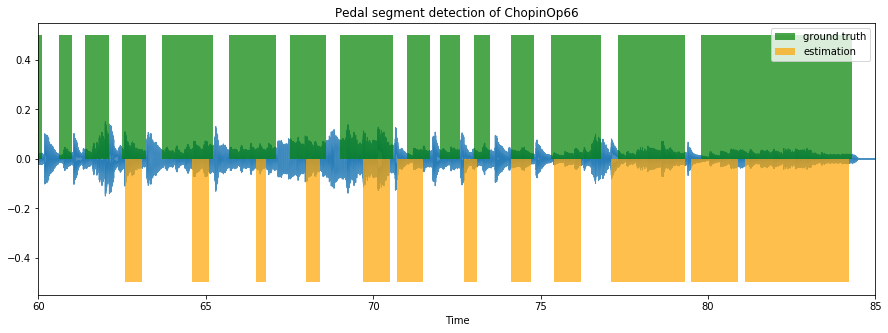

In [35]:
# plot result
frmtimes = np.arange(n_frames)*seghop_duration
left,right = [60,85]
plt.figure(figsize=(15,5))
librosa.display.waveplot(paudio, SR, alpha=0.8)
plt.fill_between(frmtimes, 0, 0.5, where=segframes_gt>0, facecolor='green', alpha=0.7, label='ground truth')
plt.fill_between(frmtimes, -0.5, 0, where=segframes_est>0, facecolor='orange', alpha=0.7, label='estimation')
plt.title("Pedal segment detection of {}".format(filename))
plt.legend()
plt.xlim([left,right])

### Do the detection on all the pieces in the testing dataset:
```
python psegment-test.py real 0.98 0.98
```

results are saved in `psegment-testresult-realaudio_onset98_seg98.csv` where variables
```
[filename_records, support0s, support1s, acc01_frms, p1_frms, r1_frms, f1_frms, fp_rates, fn_rates, 
 boundary_wins, p1_sbrs, r1_sbrs, f1_sbrs, r2e_deviation1s, e2r_deviation1s,
 p01_sbrs, r01_sbrs, f01_sbrs, r2e_deviation01s, e2r_deviation01s,
 p_pairwises, r_pairwises, f_pairwises, nce_overs, nce_unders, nce_fs, rand_indexs, 
 adjrand_indexs, mutual_infos, adjmutual_infos, normmutual_infos]
```
are associated to column names
```
['filename_record', 'support0', 'support1', 'acc01_frm', 'p1_frm', 'r1_frm', 'f1_frm', 'fp_rate', 'fn_rate', 
 'boundary_win', 'p1_sbr', 'r1_sbr', 'f1_sbr', 'r2e_deviation1', 'e2r_deviation1',
 'p01_sbr', 'r01_sbr', 'f01_sbr', 'r2e_deviation01', 'e2r_deviation01',
 'p_pairwise', 'r_pairwise', 'f_pairwise', 'nce_over', 'nce_under', 'nce_f', 'rand_index', 
 'adjrand_index', 'mutual_info', 'adjmutual_info', 'normmutual_info']
```

### Load results:

In [36]:
testresult_path = 'psegment-testresult-realaudio_onset98_seg98.csv'
testresult_tracks = pd.read_csv(testresult_path)
num_testresult_tracks = len(testresult_tracks)

print("Related statistics of testing dataset")
print("Sum of # frame label 'np': {}".format(sum(testresult_tracks.support0.values)))
print("Sum of # frame label  'p': {}".format(sum(testresult_tracks.support1.values)))
print("  Average boundary window: {0:.4f}s".format(sum(testresult_tracks.boundary_win.values)/num_testresult_tracks))
print("         Number of pieces: {}".format(num_testresult_tracks))

print("=" * 60)
print("Average metrics for frame-wise label 'p'")
print("-" * 50)
print("            Accuracy: {0:.4f}".format(sum(testresult_tracks.acc01_frm.values)/num_testresult_tracks))
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p1_frm.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r1_frm.values)/num_testresult_tracks))
print("                  F1: {0:.4f}".format(sum(testresult_tracks.f1_frm.values)/num_testresult_tracks))
print("             FP rate: {0:.4f}".format(sum(testresult_tracks.fp_rate.values)/num_testresult_tracks))
print("             FN rate: {0:.4f}".format(sum(testresult_tracks.fn_rate.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for boundary annotation 'p'")
print("-" * 50)
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p1_sbr.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r1_sbr.values)/num_testresult_tracks))
print("           F-measure: {0:.4f}".format(sum(testresult_tracks.f1_sbr.values)/num_testresult_tracks))
print("Ref-to-est deviation: {0:.4f}".format(sum(testresult_tracks.r2e_deviation1.values)/num_testresult_tracks))
print("Est-to-ref deviation: {0:.4f}".format(sum(testresult_tracks.e2r_deviation1.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for structural annotation (p+np)")
print("-" * 50)
print("  Pairwise Precision: {0:.4f}".format(sum(testresult_tracks.p_pairwise.values)/num_testresult_tracks))
print("     Pairwise Recall: {0:.4f}".format(sum(testresult_tracks.r_pairwise.values)/num_testresult_tracks))
print("  Pairwise F-measure: {0:.4f}".format(sum(testresult_tracks.f_pairwise.values)/num_testresult_tracks))
print("          Rand Index: {0:.4f}".format(sum(testresult_tracks.rand_index.values)/num_testresult_tracks))
print("            NCE Over: {0:.4f}".format(sum(testresult_tracks.nce_over.values)/num_testresult_tracks))
print("           NCE Under: {0:.4f}".format(sum(testresult_tracks.nce_under.values)/num_testresult_tracks))

print("=" * 60)
print("Average metrics for boundary annotation (p+np)")
print("-" * 50)
print("           Precision: {0:.4f}".format(sum(testresult_tracks.p01_sbr.values)/num_testresult_tracks))
print("              Recall: {0:.4f}".format(sum(testresult_tracks.r01_sbr.values)/num_testresult_tracks))
print("           F-measure: {0:.4f}".format(sum(testresult_tracks.f01_sbr.values)/num_testresult_tracks))
print("Ref-to-est deviation: {0:.4f}".format(sum(testresult_tracks.r2e_deviation01.values)/num_testresult_tracks))
print("Est-to-ref deviation: {0:.4f}".format(sum(testresult_tracks.e2r_deviation01.values)/num_testresult_tracks))

Related statistics of testing dataset
Sum of # frame label 'np': 2734
Sum of # frame label  'p': 7401
  Average boundary window: 0.5248s
         Number of pieces: 10
Average metrics for frame-wise label 'p'
--------------------------------------------------
            Accuracy: 0.5999
           Precision: 0.8559
              Recall: 0.5524
                  F1: 0.6583
             FP rate: 0.2805
             FN rate: 0.4476
Average metrics for boundary annotation 'p'
--------------------------------------------------
           Precision: 0.6732
              Recall: 0.5621
           F-measure: 0.6030
Ref-to-est deviation: 0.3401
Est-to-ref deviation: 0.1815
Average metrics for structural annotation (p+np)
--------------------------------------------------
  Pairwise Precision: 0.6334
     Pairwise Recall: 0.5577
  Pairwise F-measure: 0.5920
          Rand Index: 0.5300
            NCE Over: 0.1128
           NCE Under: 0.2236
Average metrics for boundary annotation (p+np)
------

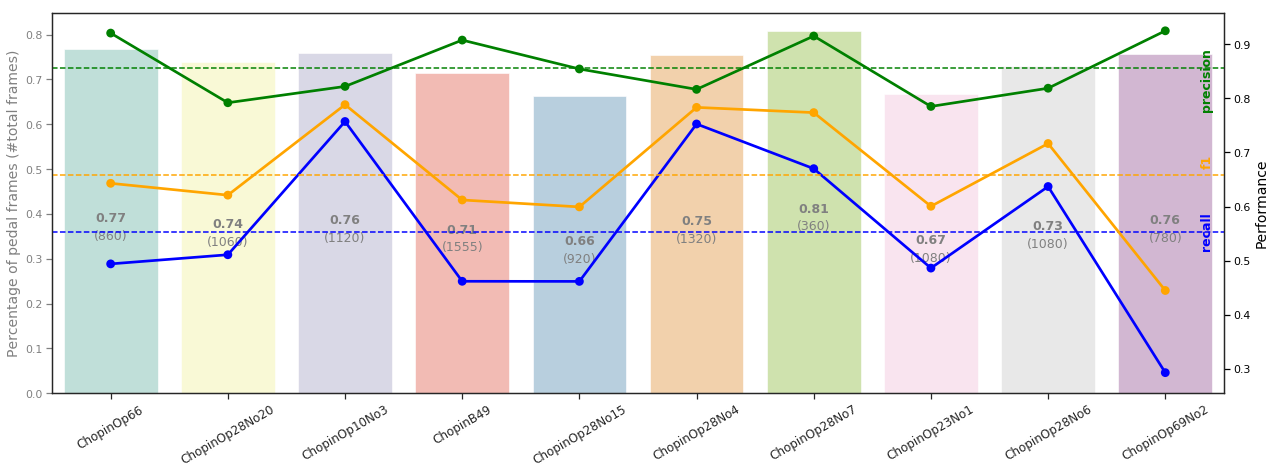

In [61]:
import seaborn as sns
p1_frm_average = sum(testresult_tracks.p1_frm.values)/num_testresult_tracks
r1_frm_average = sum(testresult_tracks.r1_frm.values)/num_testresult_tracks
f1_frm_average = sum(testresult_tracks.f1_frm.values)/num_testresult_tracks

filename_records = testresult_tracks.filename_record.values
num_piecesupport0 = [sum(testresult_tracks.loc[testresult_tracks['filename_record'] == name].support0.values) for name in filename_records]
num_piecesupport1 = [sum(testresult_tracks.loc[testresult_tracks['filename_record'] == name].support1.values) for name in filename_records]
num_piecetotal = [num_piecesupport0[idx]+num_piecesupport1[idx] for idx in range(len(filename_records))]
percentage_piecesupport1 = [num_piecesupport1[idx]/num_piecetotal[idx] for idx in range(len(filename_records))]
percentage_label = [str(np.round(s,2)) for s in percentage_piecesupport1]
pos = range(len(filename_records))

plt.figure(figsize=(21,7))
fig, ax1 = plt.subplots(figsize=(21,7))
sns.set(style="ticks", palette='Set3')
ax1_sns = sns.barplot(x=filename_records, y=percentage_piecesupport1, alpha=0.6)
xticks_loc, _ = plt.xticks(rotation=30, fontsize=12)
for tick in pos:
    ax1_sns.text(xticks_loc[tick], percentage_piecesupport1[tick]/2, percentage_label[tick], 
                horizontalalignment='center', fontsize=12.5, color='gray', weight='bold')
    ax1_sns.text(xticks_loc[tick], percentage_piecesupport1[tick]/2-0.04, '({})'.format(num_piecetotal[tick]), 
                horizontalalignment='center', fontsize=12.5, color='gray')
ax1.set_ylabel('Percentage of pedal frames (#total frames)', color='gray', fontsize=14)
ax1.tick_params('y', colors='gray')

ax2 = ax1.twinx()
ax2_p1 = sns.pointplot(x="filename_record", y="p1_frm", data=testresult_tracks, label='precision', color='green')
plt.axhline(p1_frm_average, linestyle='--', label='precision', color='green')
ax2_p1.text(xticks_loc[-1]+0.3, p1_frm_average+0.02, 'precision', rotation=90,
            fontsize=12.5, color='green', weight='bold')

ax2_r1 = sns.pointplot(x="filename_record", y="r1_frm", data=testresult_tracks, label='recall', color='blue')
plt.axhline(r1_frm_average, linestyle='--', label='recall', color='blue')
ax2_p1.text(xticks_loc[-1]+0.3, r1_frm_average+0.02, 'recall', rotation=90,
            fontsize=12.5, color='blue', weight='bold')

ax2_f1 = sns.pointplot(x="filename_record", y="f1_frm", data=testresult_tracks, label='f1', color='orange')
plt.axhline(f1_frm_average, linestyle='--', label='f1', color='orange')
ax2_p1.text(xticks_loc[-1]+0.3, f1_frm_average+0.02, 'f1', rotation=90,
            fontsize=12.5, color='orange', weight='bold')
# for tick in pos:    
#     ax2_sns.text(xticks_loc[tick]+0.028, quartile3rd[tick]+0.028, median_labels[tick], rotation=0,
#                 horizontalalignment='center', fontsize=12.5, color='black', weight='bold')
# plt.axhline(sum(testresult_tracks.f1_frm.values)/num_testresult_tracks, linestyle='--')
ax2.set_ylabel('Performance', color='black', fontsize=14)
ax2.tick_params('y', colors='black')

# plt.savefig("testfig.png", bbox_inches="tight", dpi=300)